# Data pre-processing

In [3]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [4]:
# Load the data from the uploaded CSV file
file_path = "/content/combined_mutation_CNV.csv"
data = pd.read_csv(file_path)

# Separate the features and labels
labels = data["Subtype"].values
features = data.drop(columns=["Subtype", "Sample"]).values

# Convert to numpy arrays
labels = np.array(labels)
labels[labels=='PDM'] = 0
labels[labels=='SCM'] = 1

features = np.array(features)

# Output the results
print("Labels:", labels.shape)
print("Features:", features.shape)


Labels: (43,)
Features: (43, 656)


In [5]:
# Create a MinMaxScaler object with a feature range of -1 to 1
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Fit the MinMaxScaler to the data (excluding the last column) and transform the data
# This scales the features to the specified range (-1 to 1)
features = min_max_Scalar.fit_transform(features)

# Convert the transformed data to a NumPy array
features = np.asarray(features)

# Encode labels if they are not integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# PCA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

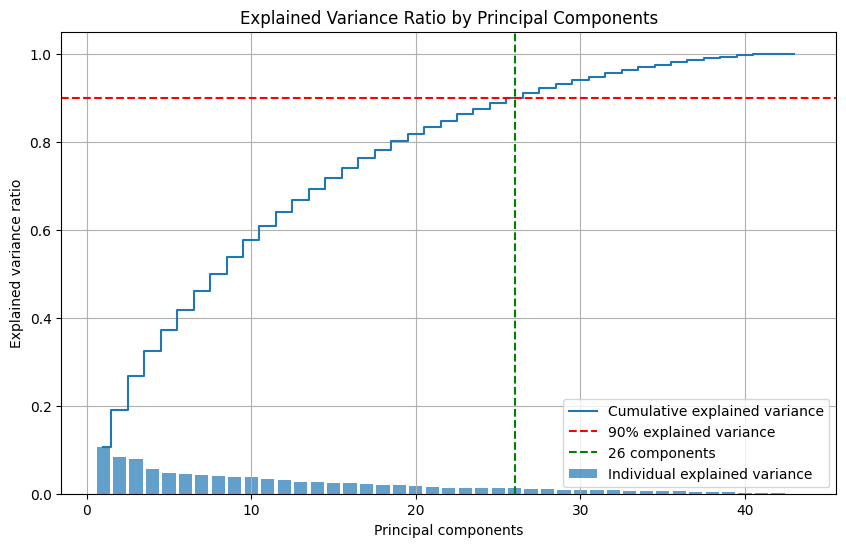

Number of components needed to explain 90% of the variance: 26


In [6]:
# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the number of components needed to explain 90% variance
n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1

# Plot explained variance ratio and cumulative explained variance
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.7,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    where="mid",
    label="Cumulative explained variance",
)
plt.axhline(y=0.90, color="r", linestyle="--", label="90% explained variance")
plt.axvline(
    x=n_components_90, color="g", linestyle="--", label=f"{n_components_90} components"
)

plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.title("Explained Variance Ratio by Principal Components")
plt.grid()
plt.show()

# Print the number of components needed to explain 90% of the variance
print(f"Number of components needed to explain 90% of the variance: {n_components_90}")


In [7]:
# Apply PCA
pca = PCA(n_components=26)
new_features = pca.fit_transform(features)

new_features.shape

(43, 26)

# GOW

In [8]:
import numpy as np
from numpy.random import rand

In [9]:
def error_rate(x, opts, model):
    fold = opts["fold"]
    xt, yt, xv, yv = fold["xt"], fold["yt"], fold["xv"], fold["yv"]

    num_train, num_valid = xt.shape[0], xv.shape[0]
    xtrain_selected = xt[:, x == 1]
    ytrain_reshaped = yt.reshape(num_train)
    xvalid_selected = xv[:, x == 1]
    yvalid_reshaped = yv.reshape(num_valid)

    mdl = model()

    mdl.fit(xtrain_selected, ytrain_reshaped)
    ypred = mdl.predict(xvalid_selected)
    accuracy = np.sum(yvalid_reshaped == ypred) / num_valid
    return 1 - accuracy


def Fun(x, opts, model):
    alpha = 0.99
    beta = 1 - alpha
    max_feat = len(x)
    num_feat = np.sum(x == 1)

    if num_feat == 0:
        return 1

    error = error_rate(x, opts, model)
    return alpha * error + beta * (num_feat / max_feat)


# Plotting the convergence curve
def plot_convergence(curve, max_iter):
    x = np.arange(1, max_iter + 1)
    plt.plot(x, curve, "o-")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Fitness")
    plt.title("PSO")
    plt.grid()
    plt.show()


def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype="float")
    for i in range(N):
        for d in range(dim):
            X[i, d] = lb[0, d] + (ub[0, d] - lb[0, d]) * rand()

    return X


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype="int")
    for i in range(N):
        for d in range(dim):
            if X[i, d] > thres:
                Xbin[i, d] = 1
            else:
                Xbin[i, d] = 0

    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub

    return x


def gwo_jfs(xtrain, ytrain, opts):
    # Parameters
    ub = 1
    lb = 0
    thres = 0.5

    N = opts["N"]
    max_iter = opts["T"]
    model = opts["model"]

    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype="float")
        lb = lb * np.ones([1, dim], dtype="float")

    # Initialize position
    X = init_position(lb, ub, N, dim)

    # Binary conversion
    Xbin = binary_conversion(X, thres, N, dim)

    # Fitness at first iteration
    fit = np.zeros([N, 1], dtype="float")
    Xalpha = np.zeros([1, dim], dtype="float")
    Xbeta = np.zeros([1, dim], dtype="float")
    Xdelta = np.zeros([1, dim], dtype="float")
    Falpha = float("inf")
    Fbeta = float("inf")
    Fdelta = float("inf")

    for i in range(N):
        fit[i, 0] = Fun(Xbin[i, :], opts, model)
        if fit[i, 0] < Falpha:
            Xalpha[0, :] = X[i, :]
            Falpha = fit[i, 0]

        if fit[i, 0] < Fbeta and fit[i, 0] > Falpha:
            Xbeta[0, :] = X[i, :]
            Fbeta = fit[i, 0]

        if fit[i, 0] < Fdelta and fit[i, 0] > Fbeta and fit[i, 0] > Falpha:
            Xdelta[0, :] = X[i, :]
            Fdelta = fit[i, 0]

    # Pre
    curve = np.zeros([1, max_iter], dtype="float")
    t = 0

    curve[0, t] = Falpha.copy()
    print("Iteration:", t + 1)
    print("Best (GWO):", curve[0, t])
    t += 1

    while t < max_iter:
        # Coefficient decreases linearly from 2 to 0
        a = 2 - t * (2 / max_iter)

        for i in range(N):
            for d in range(dim):
                # Parameter C
                C1 = 2 * rand()
                C2 = 2 * rand()
                C3 = 2 * rand()
                # Compute Dalpha, Dbeta & Ddelta
                Dalpha = abs(C1 * Xalpha[0, d] - X[i, d])
                Dbeta = abs(C2 * Xbeta[0, d] - X[i, d])
                Ddelta = abs(C3 * Xdelta[0, d] - X[i, d])
                # Parameter A
                A1 = 2 * a * rand() - a
                A2 = 2 * a * rand() - a
                A3 = 2 * a * rand() - a
                # Compute X1, X2 & X3
                X1 = Xalpha[0, d] - A1 * Dalpha
                X2 = Xbeta[0, d] - A2 * Dbeta
                X3 = Xdelta[0, d] - A3 * Ddelta
                # Update wolf
                X[i, d] = (X1 + X2 + X3) / 3
                # Boundary
                X[i, d] = boundary(X[i, d], lb[0, d], ub[0, d])

        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)

        # Fitness
        for i in range(N):
            fit[i, 0] = Fun(Xbin[i, :], opts, model)
            if fit[i, 0] < Falpha:
                Xalpha[0, :] = X[i, :]
                Falpha = fit[i, 0]

            if fit[i, 0] < Fbeta and fit[i, 0] > Falpha:
                Xbeta[0, :] = X[i, :]
                Fbeta = fit[i, 0]

            if fit[i, 0] < Fdelta and fit[i, 0] > Fbeta and fit[i, 0] > Falpha:
                Xdelta[0, :] = X[i, :]
                Fdelta = fit[i, 0]

        curve[0, t] = Falpha.copy()
        print("Iteration:", t + 1)
        print("Best (GWO):", curve[0, t])
        t += 1

    # Best feature subset
    Gbin = binary_conversion(Xalpha, thres, 1, dim)
    Gbin = Gbin.reshape(dim)
    pos = np.asarray(range(0, dim))
    sel_index = pos[Gbin == 1]
    num_feat = len(sel_index)
    # Create dictionary
    gwo_data = {"sf": sel_index, "c": curve, "nf": num_feat}

    return gwo_data


# Helper Functions


In [10]:
import json

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [11]:
def encode_labels(labels):
    """Encode labels if they are not integers."""
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(labels)

def perform_k_fold_cv(features, labels_encoded, best_params, model):
    """Perform k-fold cross-validation with the best parameters and return results."""
    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    all_classification_reports = []
    all_confusion_matrices = []

    for train_index, test_index in skf.split(features, labels_encoded):
        x_train_fold, x_test_fold = features[train_index], features[test_index]
        y_train_fold, y_test_fold = (
            labels_encoded[train_index],
            labels_encoded[test_index],
        )

        model_fold = model(**best_params)
        model_fold.fit(x_train_fold, y_train_fold)

        y_pred_fold = model_fold.predict(x_test_fold)
        accuracy_fold = metrics.accuracy_score(y_test_fold, y_pred_fold) * 100
        accuracies.append(accuracy_fold)

        classification_report_fold = classification_report(
            y_test_fold, y_pred_fold, output_dict=True
        )
        all_classification_reports.append(classification_report_fold)

        confusion_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)
        all_confusion_matrices.append(confusion_matrix_fold)

    return accuracies, all_classification_reports, all_confusion_matrices


def compute_average_classification_report(all_classification_reports):
    """Compute the average classification report."""
    return {
        key: {
            "precision": np.mean(
                [cr[key]["precision"] for cr in all_classification_reports]
            ),
            "recall": np.mean([cr[key]["recall"] for cr in all_classification_reports]),
            "f1-score": np.mean(
                [cr[key]["f1-score"] for cr in all_classification_reports]
            ),
            "support": np.mean(
                [cr[key]["support"] for cr in all_classification_reports]
            ),
        }
        for key in all_classification_reports[0].keys()
        if key != "accuracy"
    }


def plot_average_classification_report(average_classification_report):
    """Plot the average classification report."""
    categories = list(average_classification_report.keys())
    precision = [average_classification_report[cat]["precision"] for cat in categories]
    recall = [average_classification_report[cat]["recall"] for cat in categories]
    f1_score = [average_classification_report[cat]["f1-score"] for cat in categories]

    x = np.arange(len(categories))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, precision, width, label="Precision")
    rects2 = ax.bar(x, recall, width, label="Recall")
    rects3 = ax.bar(x + width, f1_score, width, label="F1-Score")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Scores")
    ax.set_title("Average Classification Report by Category")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.legend()

    fig.tight_layout()
    plt.show()


def plot_average_confusion_matrix(all_confusion_matrices):
    """Plot the average confusion matrix."""
    average_confusion_matrix = np.mean(all_confusion_matrices, axis=0)
    disp = ConfusionMatrixDisplay(confusion_matrix=average_confusion_matrix.astype(int))
    disp.plot()
    plt.show()


def main(features, labels, param_grid, model, feature_namse):
    # Encode labels if necessary
    labels_encoded = encode_labels(labels)

    # Data preparation and PSO execution
    # xtrain, xtest, ytrain, ytest = train_test_split(
    #     features, labels_encoded, test_size=0.2, stratify=labels_encoded
    # )

    # fold = {"xt": xtrain, "yt": ytrain, "xv": xtest, "yv": ytest}

    fold = {"xt": features, "yt": labels_encoded, "xv": features, "yv": labels_encoded}

    opts = {
        "N": 100,
        "T": 100,
        "model": model,
        "fold": fold
    }

    fmdl = gwo_jfs(features, labels_encoded, opts)

    print("Selected Features:", fmdl["sf"])
    print("Feature Size:", fmdl["nf"])

    # Plot convergence
    plot_convergence(fmdl["c"][0], opts["T"])


    data = features[:, fmdl["sf"]]

    # Perform Grid Search to find the best parameters
    grid_search = GridSearchCV(
        model(), param_grid, cv=StratifiedKFold(n_splits=5), scoring="accuracy"
    )

    grid_search.fit(data, labels_encoded)
    best_params = grid_search.best_params_

    print("Best parameters found by GridSearchCV: ", best_params)

    # Perform k-fold cross-validation
    accuracies, all_classification_reports, all_confusion_matrices = perform_k_fold_cv(
        data, labels_encoded, best_params, model
    )

    # Print average accuracy
    mean_accuracy = np.mean(accuracies)
    print("Mean accuracy over all folds: {:.2f}%".format(mean_accuracy))

    # Compute and print average classification report
    average_classification_report = compute_average_classification_report(
        all_classification_reports
    )
    print(
        "Average Classification Report:\n",
        json.dumps(average_classification_report, indent=4),
    )

    # Plot average confusion matrix
    plot_average_confusion_matrix(all_confusion_matrices)

    # Plot average classification report
    plot_average_classification_report(average_classification_report)

    return mean_accuracy, feature_namse[np.sort(fmdl["sf"])].to_list()



# Support Vector Machines (SVM)

In [ ]:
import warnings

from sklearn.svm import SVC

Iteration: 1
Best (GWO): 0.004725609756097565
Iteration: 2
Best (GWO): 0.00446646341463415
Iteration: 3
Best (GWO): 0.004253048780487809
Iteration: 4
Best (GWO): 0.003887195121951223
Iteration: 5
Best (GWO): 0.003445121951219515
Iteration: 6
Best (GWO): 0.0033384146341463444
Iteration: 7
Best (GWO): 0.0030335365853658564
Iteration: 8
Best (GWO): 0.002850609756097563
Iteration: 9
Best (GWO): 0.0026676829268292707
Iteration: 10
Best (GWO): 0.002530487804878051
Iteration: 11
Best (GWO): 0.002225609756097563
Iteration: 12
Best (GWO): 0.0021798780487804897
Iteration: 13
Best (GWO): 0.0020121951219512213
Iteration: 14
Best (GWO): 0.0019054878048780505
Iteration: 15
Best (GWO): 0.0018750000000000017
Iteration: 16
Best (GWO): 0.0016463414634146356
Iteration: 17
Best (GWO): 0.0016463414634146356
Iteration: 18
Best (GWO): 0.0016006097560975624
Iteration: 19
Best (GWO): 0.001585365853658538
Iteration: 20
Best (GWO): 0.001387195121951221
Iteration: 21
Best (GWO): 0.0013262195121951231
Iteration: 2

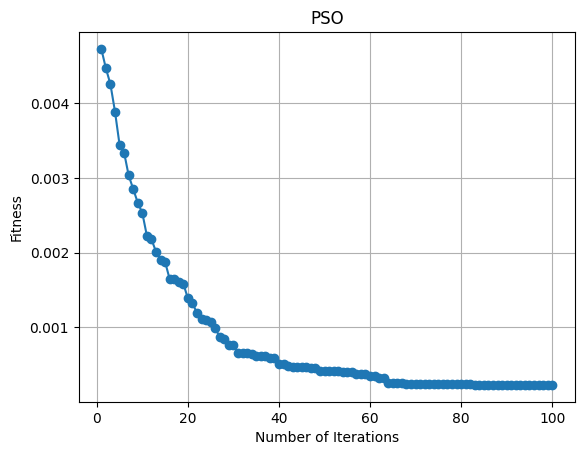

Best parameters found by GridSearchCV:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mean accuracy over all folds: 78.89%
Average Classification Report:
 {
    "0": {
        "precision": 0.7933333333333333,
        "recall": 0.8,
        "f1-score": 0.7711111111111111,
        "support": 4.0
    },
    "1": {
        "precision": 0.8433333333333334,
        "recall": 0.79,
        "f1-score": 0.7977777777777778,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.8183333333333334,
        "recall": 0.795,
        "f1-score": 0.7844444444444445,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.8248148148148147,
        "recall": 0.7888888888888889,
        "f1-score": 0.7844444444444445,
        "support": 8.6
    }
}


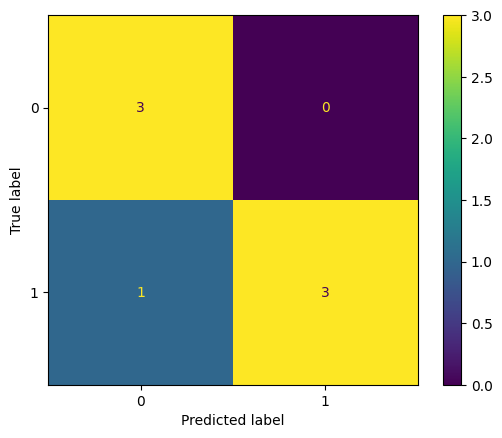

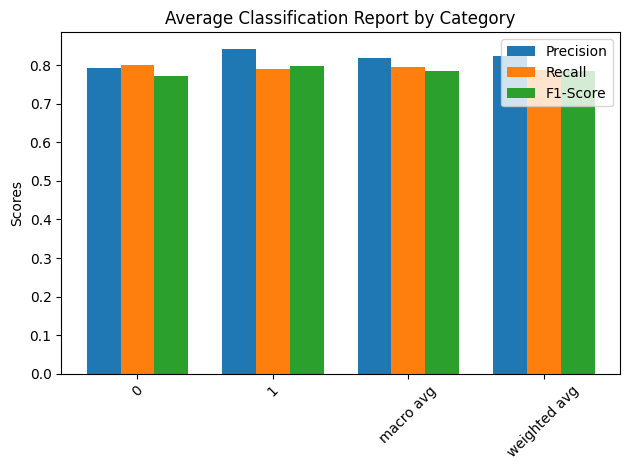

(78.88888888888889,
 ['LRP1B_Missense_Mutation',
  'CBL_Missense_Mutation',
  'PIK3C2G_Missense_Mutation',
  'NOTCH3_Missense_Mutation',
  'CUX1_Missense_Mutation',
  'TET2_Missense_Mutation',
  'TOP2A_Missense_Mutation',
  'SUFU_logCR',
  'CREBBP_logCR',
  'PRKAR1A_logCR',
  'EP300_logCR',
  'SLIT2_logCR',
  'FAM175A_logCR',
  'CUX1_logCR',
  'LYN_logCR'])

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

main(new_features, labels, param_grid, SVC, data.columns[2:])


# k-Nearest Neighbors (k-NN)


In [ ]:
import warnings

from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"n_neighbors": np.arange(2, 10)}

main(new_features, labels, param_grid, KNeighborsClassifier, data.columns[2:])

# Logistic Regression

In [ ]:
import warnings

from sklearn.linear_model import LogisticRegression

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

main(new_features, labels, param_grid, LogisticRegression, data.columns[2:])

# Decision Trees

In [ ]:
import warnings

from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

main(new_features, labels, param_grid, DecisionTreeClassifier, data.columns[2:])

# Random Forest

In [ ]:
import warnings

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

main(new_features, labels, param_grid, RandomForestClassifier, data.columns[2:])


# XGBoost


In [ ]:
import warnings

import xgboost as xgb

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

main(new_features, labels, param_grid, xgb_model, data.columns[2:])

# All Info

In [12]:
import warnings

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Iteration: 1
Best (GWO): 0.050661896243291565
Iteration: 2
Best (GWO): 0.027638640429338147
Iteration: 3
Best (GWO): 0.027638640429338147
Iteration: 4
Best (GWO): 0.027638640429338147
Iteration: 5
Best (GWO): 0.02725402504472276
Iteration: 6
Best (GWO): 0.02686940966010738
Iteration: 7
Best (GWO): 0.02686940966010738
Iteration: 8
Best (GWO): 0.02686940966010738
Iteration: 9
Best (GWO): 0.02610017889087661
Iteration: 10
Best (GWO): 0.02610017889087661
Iteration: 11
Best (GWO): 0.00307692307692308
Iteration: 12
Best (GWO): 0.0026923076923076944
Iteration: 13
Best (GWO): 0.0026923076923076944
Iteration: 14
Best (GWO): 0.0026923076923076944
Iteration: 15
Best (GWO): 0.0026923076923076944
Iteration: 16
Best (GWO): 0.0026923076923076944
Iteration: 17
Best (GWO): 0.0026923076923076944
Iteration: 18
Best (GWO): 0.0026923076923076944
Iteration: 19
Best (GWO): 0.0026923076923076944
Iteration: 20
Best (GWO): 0.0026923076923076944
Iteration: 21
Best (GWO): 0.0026923076923076944
Iteration: 22
Best 

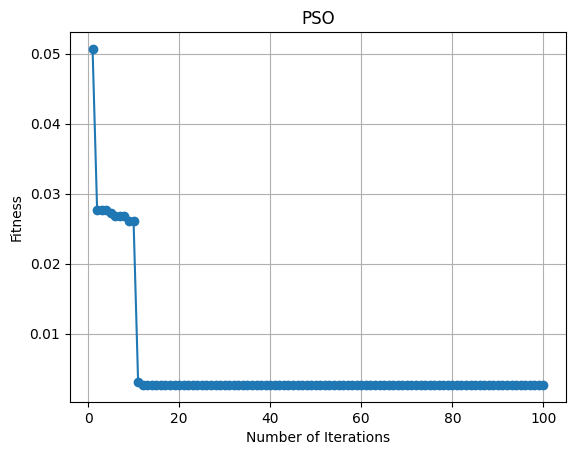

Best parameters found by GridSearchCV:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Mean accuracy over all folds: 74.72%
Average Classification Report:
 {
    "0": {
        "precision": 0.6933333333333334,
        "recall": 0.85,
        "f1-score": 0.7599999999999999,
        "support": 4.0
    },
    "1": {
        "precision": 0.8333333333333333,
        "recall": 0.6599999999999999,
        "f1-score": 0.7309523809523809,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7633333333333334,
        "recall": 0.7550000000000001,
        "f1-score": 0.7454761904761904,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7703703703703704,
        "recall": 0.7472222222222222,
        "f1-score": 0.7449206349206349,
        "support": 8.6
    }
}


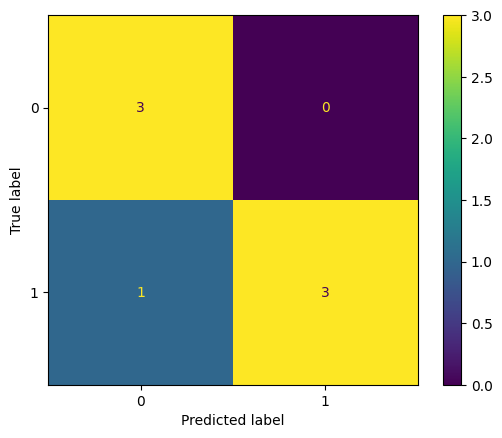

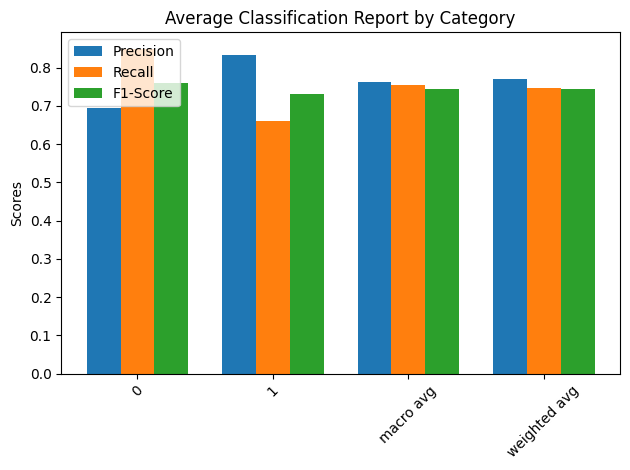

Iteration: 1
Best (GWO): 0.16654740608228974
Iteration: 2
Best (GWO): 0.12011627906976743
Iteration: 3
Best (GWO): 0.11896243291592128
Iteration: 4
Best (GWO): 0.09786225402504478
Iteration: 5
Best (GWO): 0.09593917710196785
Iteration: 6
Best (GWO): 0.09593917710196785
Iteration: 7
Best (GWO): 0.0947853309481217
Iteration: 8
Best (GWO): 0.09401610017889094
Iteration: 9
Best (GWO): 0.09363148479427555
Iteration: 10
Best (GWO): 0.0713774597495528
Iteration: 11
Best (GWO): 0.07099284436493741
Iteration: 12
Best (GWO): 0.07099284436493741
Iteration: 13
Best (GWO): 0.07099284436493741
Iteration: 14
Best (GWO): 0.07099284436493741
Iteration: 15
Best (GWO): 0.07099284436493741
Iteration: 16
Best (GWO): 0.07099284436493741
Iteration: 17
Best (GWO): 0.07099284436493741
Iteration: 18
Best (GWO): 0.07099284436493741
Iteration: 19
Best (GWO): 0.07099284436493741
Iteration: 20
Best (GWO): 0.07099284436493741
Iteration: 21
Best (GWO): 0.07099284436493741
Iteration: 22
Best (GWO): 0.07099284436493741

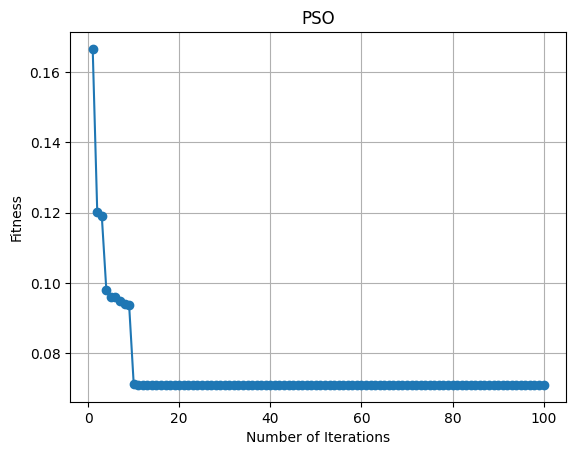

Best parameters found by GridSearchCV:  {'n_neighbors': 3}
Mean accuracy over all folds: 73.89%
Average Classification Report:
 {
    "0": {
        "precision": 0.8,
        "recall": 0.7,
        "f1-score": 0.6958730158730158,
        "support": 4.0
    },
    "1": {
        "precision": 0.7642857142857143,
        "recall": 0.78,
        "f1-score": 0.7526695526695527,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7821428571428573,
        "recall": 0.74,
        "f1-score": 0.7242712842712842,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7841798941798941,
        "recall": 0.7388888888888888,
        "f1-score": 0.7248484848484849,
        "support": 8.6
    }
}


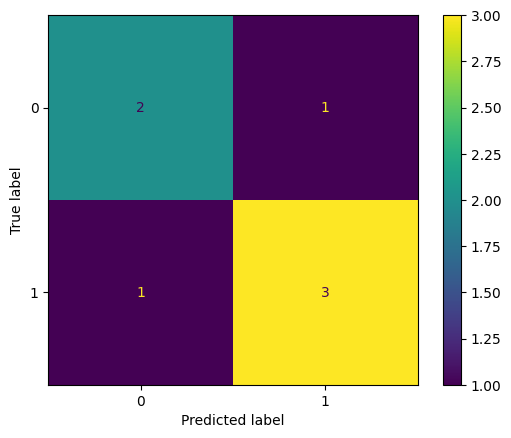

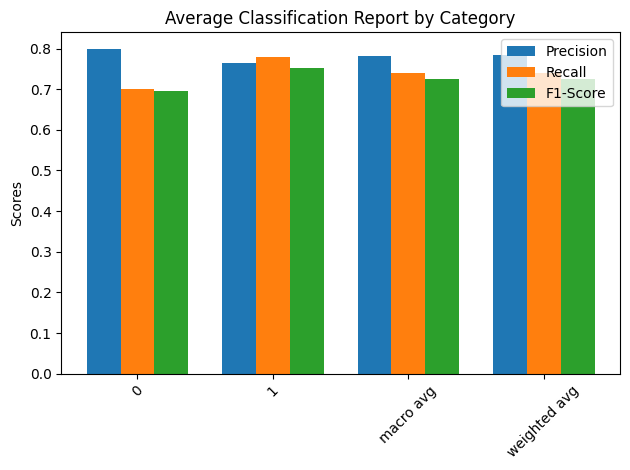

Iteration: 1
Best (GWO): 0.09632379248658324
Iteration: 2
Best (GWO): 0.07406976744186049
Iteration: 3
Best (GWO): 0.05220035778175311
Iteration: 4
Best (GWO): 0.050661896243291565
Iteration: 5
Best (GWO): 0.050661896243291565
Iteration: 6
Best (GWO): 0.050661896243291565
Iteration: 7
Best (GWO): 0.03071556350626123
Iteration: 8
Best (GWO): 0.03071556350626123
Iteration: 9
Best (GWO): 0.03071556350626123
Iteration: 10
Best (GWO): 0.03071556350626123
Iteration: 11
Best (GWO): 0.03071556350626123
Iteration: 12
Best (GWO): 0.030330948121645843
Iteration: 13
Best (GWO): 0.02840787119856892
Iteration: 14
Best (GWO): 0.028023255813953533
Iteration: 15
Best (GWO): 0.027638640429338147
Iteration: 16
Best (GWO): 0.027638640429338147
Iteration: 17
Best (GWO): 0.027638640429338147
Iteration: 18
Best (GWO): 0.027638640429338147
Iteration: 19
Best (GWO): 0.02725402504472276
Iteration: 20
Best (GWO): 0.02725402504472276
Iteration: 21
Best (GWO): 0.02725402504472276
Iteration: 22
Best (GWO): 0.027254

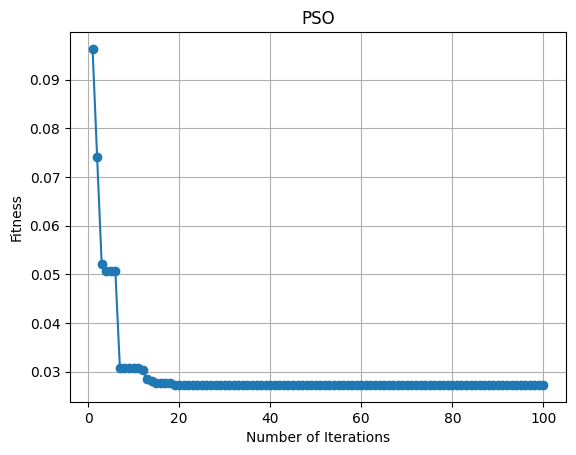

Best parameters found by GridSearchCV:  {'C': 100, 'solver': 'lbfgs'}
Mean accuracy over all folds: 74.44%
Average Classification Report:
 {
    "0": {
        "precision": 0.7833333333333333,
        "recall": 0.75,
        "f1-score": 0.7347619047619047,
        "support": 4.0
    },
    "1": {
        "precision": 0.7933333333333332,
        "recall": 0.74,
        "f1-score": 0.7351515151515151,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7883333333333333,
        "recall": 0.745,
        "f1-score": 0.73495670995671,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7888888888888888,
        "recall": 0.7444444444444445,
        "f1-score": 0.7349783549783551,
        "support": 8.6
    }
}


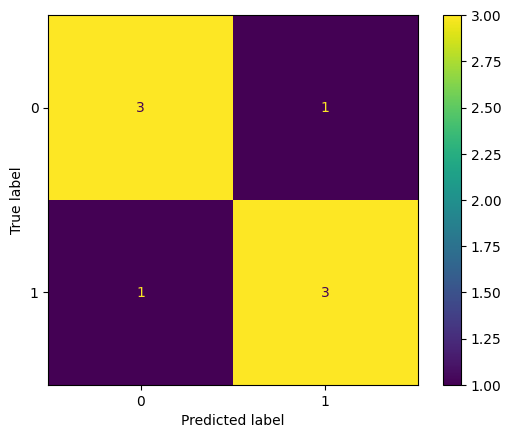

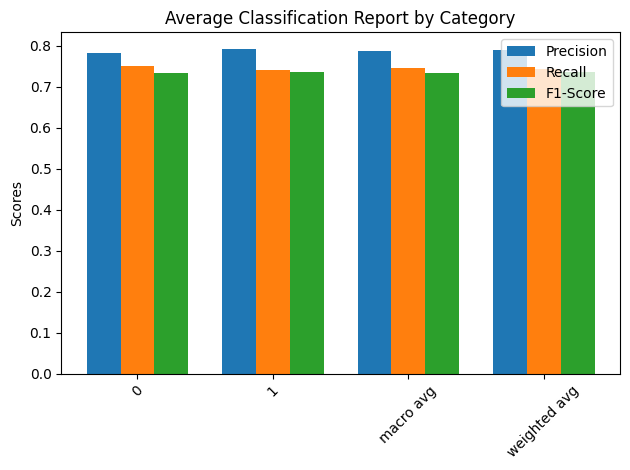

Iteration: 1
Best (GWO): 0.00307692307692308
Iteration: 2
Best (GWO): 0.001153846153846155
Iteration: 3
Best (GWO): 0.001153846153846155
Iteration: 4
Best (GWO): 0.00076923076923077
Iteration: 5
Best (GWO): 0.000384615384615385
Iteration: 6
Best (GWO): 0.000384615384615385
Iteration: 7
Best (GWO): 0.000384615384615385
Iteration: 8
Best (GWO): 0.000384615384615385
Iteration: 9
Best (GWO): 0.000384615384615385
Iteration: 10
Best (GWO): 0.000384615384615385
Iteration: 11
Best (GWO): 0.000384615384615385
Iteration: 12
Best (GWO): 0.000384615384615385
Iteration: 13
Best (GWO): 0.000384615384615385
Iteration: 14
Best (GWO): 0.000384615384615385
Iteration: 15
Best (GWO): 0.000384615384615385
Iteration: 16
Best (GWO): 0.000384615384615385
Iteration: 17
Best (GWO): 0.000384615384615385
Iteration: 18
Best (GWO): 0.000384615384615385
Iteration: 19
Best (GWO): 0.000384615384615385
Iteration: 20
Best (GWO): 0.000384615384615385
Iteration: 21
Best (GWO): 0.000384615384615385
Iteration: 22
Best (GWO)

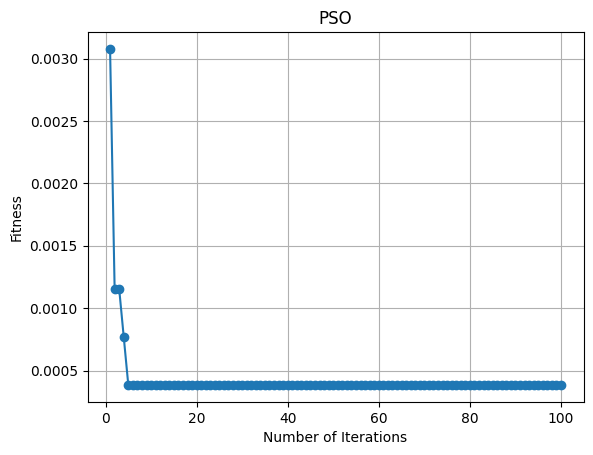

Best parameters found by GridSearchCV:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean accuracy over all folds: 67.50%
Average Classification Report:
 {
    "0": {
        "precision": 0.6476190476190476,
        "recall": 0.7,
        "f1-score": 0.6435497835497836,
        "support": 4.0
    },
    "1": {
        "precision": 0.78,
        "recall": 0.67,
        "f1-score": 0.682063492063492,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7138095238095239,
        "recall": 0.6849999999999999,
        "f1-score": 0.6628066378066378,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7233862433862434,
        "recall": 0.675,
        "f1-score": 0.6616305916305917,
        "support": 8.6
    }
}


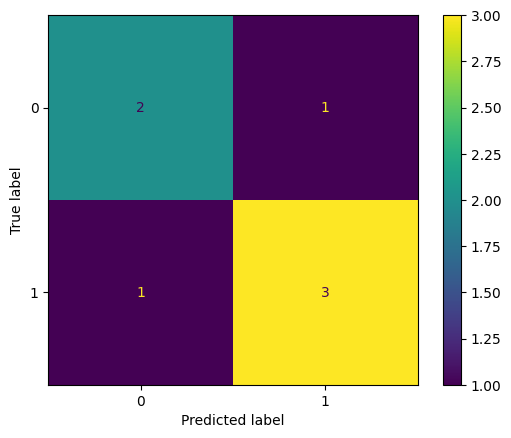

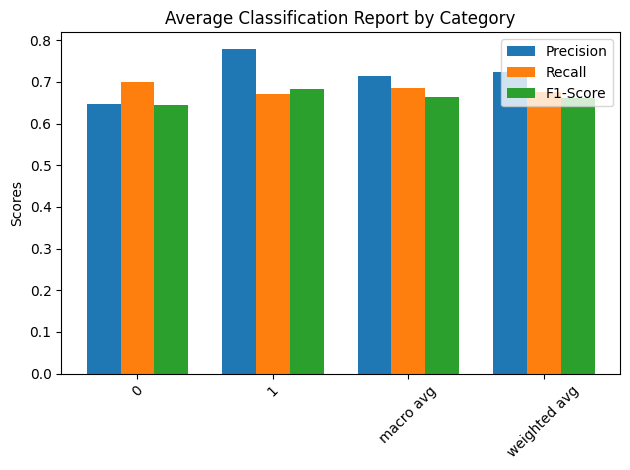

Iteration: 1
Best (GWO): 0.00230769230769231
Iteration: 2
Best (GWO): 0.001923076923076925
Iteration: 3
Best (GWO): 0.001153846153846155
Iteration: 4
Best (GWO): 0.001153846153846155
Iteration: 5
Best (GWO): 0.001153846153846155
Iteration: 6
Best (GWO): 0.00076923076923077
Iteration: 7
Best (GWO): 0.00076923076923077
Iteration: 8
Best (GWO): 0.00076923076923077
Iteration: 9
Best (GWO): 0.00076923076923077
Iteration: 10
Best (GWO): 0.00076923076923077
Iteration: 11
Best (GWO): 0.00076923076923077
Iteration: 12
Best (GWO): 0.00076923076923077
Iteration: 13
Best (GWO): 0.00076923076923077
Iteration: 14
Best (GWO): 0.00076923076923077
Iteration: 15
Best (GWO): 0.00076923076923077
Iteration: 16
Best (GWO): 0.00076923076923077
Iteration: 17
Best (GWO): 0.00076923076923077
Iteration: 18
Best (GWO): 0.00076923076923077
Iteration: 19
Best (GWO): 0.00076923076923077
Iteration: 20
Best (GWO): 0.00076923076923077
Iteration: 21
Best (GWO): 0.00076923076923077
Iteration: 22
Best (GWO): 0.00076923076

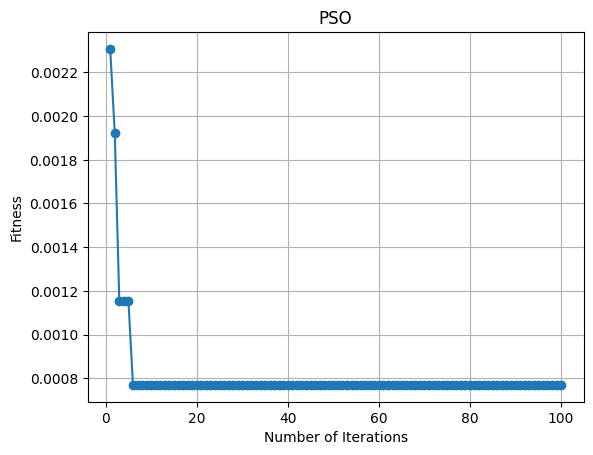

Best parameters found by GridSearchCV:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean accuracy over all folds: 55.83%
Average Classification Report:
 {
    "0": {
        "precision": 0.6,
        "recall": 0.55,
        "f1-score": 0.5012121212121212,
        "support": 4.0
    },
    "1": {
        "precision": 0.6342857142857143,
        "recall": 0.5900000000000001,
        "f1-score": 0.5568831168831169,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6171428571428571,
        "recall": 0.57,
        "f1-score": 0.5290476190476191,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6238095238095237,
        "recall": 0.5583333333333333,
        "f1-score": 0.5255411255411255,
        "support": 8.6
    }
}


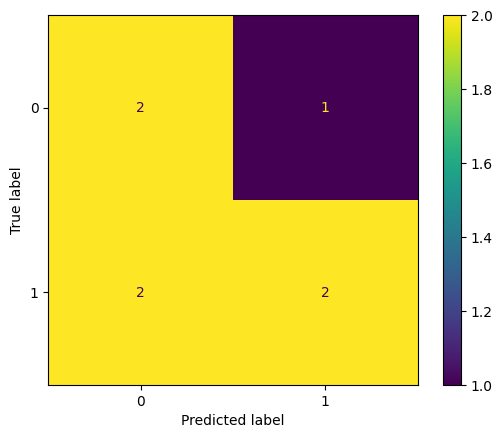

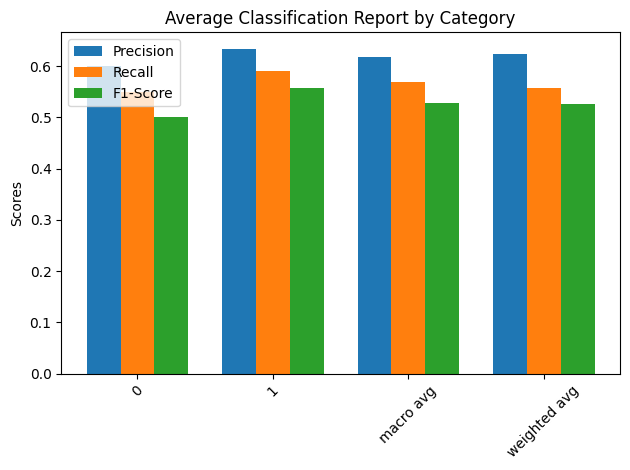

In [13]:
# Suppress all warnings
warnings.filterwarnings("ignore")

plot_results = {}
features_results = {}

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

plot_results["SVM"], features_results["SVM"] = main(
    new_features, labels, param_grid, SVC, data.columns[2:]
)

param_grid = {"n_neighbors": np.arange(2, 10)}

plot_results["KNeighborsClassifier"], features_results["KNeighborsClassifier"] = main(
    new_features, labels, param_grid, KNeighborsClassifier, data.columns[2:]
)

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

plot_results["LogisticRegression"], features_results["LogisticRegression"] = main(
    new_features, labels, param_grid, LogisticRegression, data.columns[2:]
)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

plot_results["DecisionTreeClassifier"], features_results["DecisionTreeClassifier"] = (
    main(new_features, labels, param_grid, DecisionTreeClassifier, data.columns[2:])
)

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

plot_results["XGBoost"], features_results["XGBoost"] = (
    main(new_features, labels, param_grid, xgb_model, data.columns[2:])
)

In [14]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(plot_results.items()), columns=['Classifier', 'Accuracy'])

# Save DataFrame to CSV file
df.to_csv('/content/ML_PCA_GOW.csv', index=False)
